In [37]:
# Imports
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from tempfile import TemporaryDirectory
import seaborn as sns
import time
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
import numpy as np
import pandas as pd
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(1991)
torch.manual_seed(1991)
torch.cuda.manual_seed(1991)

import random
random.seed(1991)

import numpy as np
np.random.seed(1991)


Running on device: CUDA


In [2]:
# CIFAR 10 dataset
torch.manual_seed(1991)
# Transformations
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

# Train data
train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)
# Train loader
train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)

# Test data
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)
# Test loader
test_loader = DataLoader(test_set, batch_size=256, shuffle=True, num_workers=2)

100%|██████████| 170498071/170498071 [00:04<00:00, 42327121.64it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


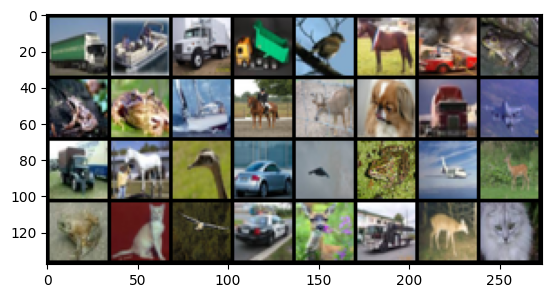

In [3]:
# Display train images

# Create helper loader
# Train loader
torch.manual_seed(1991)
train_images_display_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)

batch_generator = enumerate(train_images_display_loader)
i, batch = next(batch_generator, 0)

grid_img = torchvision.utils.make_grid(batch[0], nrow=8)
plt.imshow(grid_img.permute(1, 2, 0))

In [4]:
# Add helping dicts
dataloaders = {
    "train": train_loader,
    "val": test_loader
}

dataset_sizes = {"train": len(train_set), "val": len(test_set)}



In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    torch.manual_seed(1991)
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1000

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(DEVICE)
                    labels = labels.to(DEVICE)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train' and scheduler:
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val loss: {best_loss:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model


In [24]:

# Train ResNet18
torch.manual_seed(1991)
model_train_reg = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
model_train_reg = model_train_reg.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_train_reg.parameters(), lr=0.001, weight_decay=1e-5)

# Decay LR by a factor of 0.001 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=45, gamma=0.001)

In [25]:
model_train_reg

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
layer1 = model_train_reg.layer1

for indx in range(len(layer1)):
  modified_layers = []
  for feature in layer1[indx].children():
    modified_layers.append(feature)
    if isinstance(feature, nn.ReLU):
      modified_layers.append(nn.Dropout3d(p=0.15))

  model_train_reg.layer1[indx] = nn.Sequential(*modified_layers)



layer2 = model_train_reg.layer2

for indx in [1]:
  modified_layers = []
  for feature in layer2[indx].children():
    modified_layers.append(feature)
    if isinstance(feature, nn.ReLU):
      modified_layers.append(nn.Dropout3d(p=0.15))

  model_train_reg.layer2[indx] = nn.Sequential(*modified_layers)

layer3 = model_train_reg.layer3

for indx in [1]:
  modified_layers = []
  for feature in layer3[indx].children():
    modified_layers.append(feature)
    if isinstance(feature, nn.ReLU):
      modified_layers.append(nn.Dropout2d(p=0.15))

  model_train_reg.layer3[indx] = nn.Sequential(*modified_layers)

layer4 = model_train_reg.layer4

for indx in [1]:
  modified_layers = []
  for feature in layer4[indx].children():
    modified_layers.append(feature)
    if isinstance(feature, nn.ReLU):
      modified_layers.append(nn.Dropout2d(p=0.15))

  model_train_reg.layer4[indx] = nn.Sequential(*modified_layers)

In [27]:
model_train_reg

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout3d(p=0.15, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): R

In [28]:
# Train model Resnet18 21 epochs
model_train_reg = train_model(model_train_reg, criterion, optimizer_ft, None,
                       num_epochs=120)

Epoch 0/119
----------
train Loss: 1.8582 Acc: 0.3016
val Loss: 2.1207 Acc: 0.2990

Epoch 1/119
----------
train Loss: 1.6466 Acc: 0.3837
val Loss: 1.3341 Acc: 0.5380

Epoch 2/119
----------
train Loss: 1.5492 Acc: 0.4208
val Loss: 1.1635 Acc: 0.6026

Epoch 3/119
----------
train Loss: 1.4755 Acc: 0.4499
val Loss: 1.1490 Acc: 0.5935

Epoch 4/119
----------
train Loss: 1.4257 Acc: 0.4655
val Loss: 1.1226 Acc: 0.6061

Epoch 5/119
----------
train Loss: 1.3773 Acc: 0.4852
val Loss: 1.6055 Acc: 0.4685

Epoch 6/119
----------
train Loss: 1.3474 Acc: 0.4973
val Loss: 0.9624 Acc: 0.6672

Epoch 7/119
----------
train Loss: 1.2973 Acc: 0.5136
val Loss: 0.9290 Acc: 0.6902

Epoch 8/119
----------
train Loss: 1.2784 Acc: 0.5204
val Loss: 0.9460 Acc: 0.6788

Epoch 9/119
----------
train Loss: 1.2496 Acc: 0.5322
val Loss: 0.9330 Acc: 0.6801

Epoch 10/119
----------
train Loss: 1.2275 Acc: 0.5369
val Loss: 0.9573 Acc: 0.6833

Epoch 11/119
----------
train Loss: 1.1904 Acc: 0.5529
val Loss: 0.8572 Acc

In [29]:
torch.save(model_train_reg.state_dict(), "cifar10_resnet18_l2_dropout_regularization.pt")

In [30]:
model_train_reg.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout3d(p=0.15, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): R

In [32]:
# Check accuracy

def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for i, (inputs, targets) in enumerate(loader, 0):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total


print(f"Train set accuracy: {100.0 * accuracy(model_train_reg, train_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model_train_reg, test_loader):0.1f}%")

Train set accuracy: 89.3%
Test set accuracy: 73.6%


In [33]:
df_dict = {
    "label": [],
    "last_conv_layer": [],
    "train": [],
    "loss": []
}

In [34]:
total_num = 0
criterion = nn.CrossEntropyLoss(reduction="none")
for i, batch in enumerate(train_loader, 0):
  images, labels = batch
  images = images.to(DEVICE)
  for image, label in zip(images, labels):
    logits = model_train_reg(image.unsqueeze(0))
    total_num += 1
    losses = criterion(logits, label.unsqueeze(0).to(DEVICE)).numpy(force=True)

    df_dict["loss"].append(losses[0])
    df_dict["label"].append(label)
    df_dict["train"].append("Тренувальний набір")
    if total_num >= 10000:
      break
  if total_num >= 10000:
    break



In [35]:
total_num = 0
for i, batch in enumerate(test_loader, 0):
  images, labels = batch
  images = images.to(DEVICE)
  for image, label in zip(images, labels):
    logits = model_train_reg(image.unsqueeze(0))
    total_num += 1
    losses = criterion(logits, label.unsqueeze(0).to(DEVICE)).numpy(force=True)

    df_dict["loss"].append(losses[0])
    df_dict["label"].append(label)
    df_dict["train"].append("Тестовий набір")

In [38]:


df = pd.DataFrame.from_dict({
    "train": df_dict["train"],
    "loss": df_dict["loss"]
})


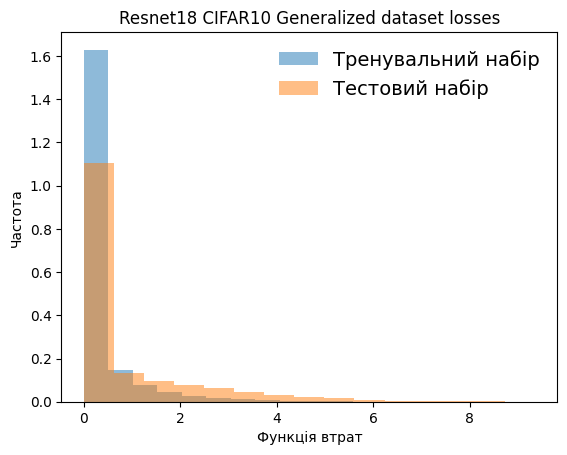

In [40]:

plt.title(f"Resnet18 CIFAR10 Generalized dataset losses")
plt.hist(df.loc[df["train"] == "Тренувальний набір"]["loss"], density=True, alpha=0.5, bins=15, label="Тренувальний набір")
plt.hist(df.loc[df["train"] == "Тестовий набір"]["loss"], density=True, alpha=0.5, bins=15, label="Тестовий набір")

plt.ylabel("Частота")
plt.xlabel("Функція втрат")
plt.legend(frameon=False, fontsize=14)
plt.show()

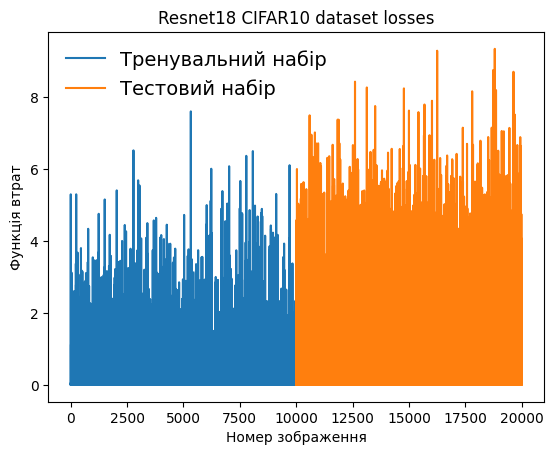

In [41]:

plt.title(f"Resnet18 CIFAR10 dataset losses")
plt.plot(df.loc[df["train"] == "Тренувальний набір"]["loss"], label="Тренувальний набір")
plt.plot(df.loc[df["train"] == "Тестовий набір"]["loss"], label="Тестовий набір")

plt.ylabel("Функція втрат")
plt.xlabel("Номер зображення")
plt.legend(frameon=False, fontsize=14)
plt.show()
